# Force layout

Le graphe est un objet abstrait pouvant servir de cadre à des données de natures très différentes (cf [quelques exemples](https://blog.trentesaux.fr/informatique/graph/)). Pourtant, il peut être intéressant de le représenter sous une forme schématique (disques et segments) en deux dimensions, afin d'identifier visuellement certaines de ses propriétés sur papier ou écran. On peut par exemple se rendre compte de :

- la [densité du graphe](https://fr.wikipedia.org/wiki/Densit%C3%A9_d'un_graphe) (nombre de liens par rapport aux nombre de noeuds) et de ses régions
- la présence de noeuds très connectés (degré très supérieur à la moyenne)
- la présence de régions isolées peu connectées au reste
- les régions plus centrales ou périphériques

Il existe de très nombreuses techniques de visualisation, toutes adaptées à des contextes différents, mais celle dont nous allons parler dans ce chapitre en est une à caractère illustratif qui se prête bien aux graphes sociaux.

## Critères visuels

Pour produire une "bonne" visualisation, nous devons d'abord préciser ce que nous entendons par là. Nous pouvons lister un ensemble de critères intuitifs. ⚠️ Attention, ces critères ne sont aucunement simples et chacun peut soulever des questions scientifiques compliquées, tant du point de vue de la définition que de la mise en pratique.

1. minimiser le nombre de croisements entre les segments qui représentent les liens (cf dépliage de graphe, lié à [nombre de croisements](https://fr.wikipedia.org/wiki/Nombre_de_croisements_(th%C3%A9orie_des_graphes)))
1. la distance euclidienne entre deux disques représente la distance entre deux noeuds (cf définitions de distance, dont [distance](https://fr.wikipedia.org/wiki/Distance_(th%C3%A9orie_des_graphes)))
1. le dessin doit faire apparaître des communautés (cf détection de communauté)

Chaque critère ci-dessus peut faire l'objet d'une étude ciblée approfondie, mais nous nous contenterons pour l'instant d'évaluer à quel point les méthodes suivantes répondent à ces critères dans l'idée de trouver un compromis (et non une méthode exacte).

## Énergie et force

Comme tout problème d'optimisation, nous cherchons à définir une fonction de coût ou "énergie du système" $E(X)$ et à trouver la valeur $\bar{X}$ qui la minimise. Une approche peut consister à réaliser une [descente de gradient](https://fr.wikipedia.org/wiki/Algorithme_du_gradient), mais si l'on choisit une fonction d'énergie dérivable, on peut utilise la [méthode de Newton](https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Newton) et définir une force qui dérive de cette énergie potentielle $\vec{F}=-\vec{\nabla}E$. Voilà d'où le *force layout* tient son nom. Cette analogie avec les forces permet de choisir des fonctions de manière intuitive pour chercher à remplir nos critères visuels.

### Lois de Newton

Puisque nous faisons une simulation de force, nous pouvons nous inpirer des trois lois de Newton :

1. mouvement rectiligne uniforme dans un référentiel galiléen
2. principe fondamental de la dynamique, $ \sum{\vec{F}_i} = m\vec{a} $
3. principe de réaction, $\vec{\mathrm{F}}_{\mathrm{A/B}} = -\vec{\mathrm{F}}_{\mathrm{B/A}}$ et $\vec{F}_{A/B}\wedge\vec{AB} = \vec{0}$.

### Liste de forces courantes

Les forces sont liés à des propriétés de l'objet considéré (masse, charge, raideur d'un ressort) et à la distance qui les sépare.

- force gravitationnelle (attractive) $F = G\frac{m_am_b}{d^2}$
- force électrostatique (répulsive si charge de même signe) $F = -\frac{q_aq_b}{4\pi\epsilon_0d^2}$
- force d'un ressort (en fonction de la longueur à l'équilibre) $F = k(l-l_0)$

Nous essayons par la suite plusieurs combinaison de ces forces pour voir comment elles répondent à des critères visuels ou autres.

## Implémentation des critères

### Nombre d'intersections

In [22]:
using Test

"""takes x and y coordinates of three points (3×2 matrix)
returns wether it is a strictly clockwise triangle""" 
is_clockwise(coord) = (coord[2,1]-coord[1,1]) * (coord[3,2]-coord[1,2]) > (coord[3,1]-coord[1,1]) * (coord[2,2]-coord[1,2])

"""takes x and y coordinates of the four points of the two segments (4×2 matrix)
returns wether they intersect (ignoring edge cases)"""
do_intersect(coord) = ( is_clockwise(coord[[1,2,3],:]) != is_clockwise(coord[[1,2,4],:]) &&
    is_clockwise(coord[[1,3,4],:]) != is_clockwise(coord[[2,3,4],:]) )

"""takes a graph and the coords of it's vertices"""
function count_intersects(g, coord)
    E = ne(g)
    ed = collect(edges(g))
    count = 0
    for i in 1:E
        for j in 1:i-1
            @inbounds count += Int(do_intersect(coord[[ed[i].src, ed[i].dst, ed[j].src, ed[j].dst], :]))
        end
    end
    return count
end

@test do_intersect([-1 0; 1 0; 0 -1; 0 1]) == true
@test do_intersect([-1 0; 1 0; 0 1; 0 2]) == false

Test Passed

### Modèle d'énergie d'Andreas Noack

Certaines mesures de qualité sont rassemblées dans la thèse d'Andreas Noack [[1]](#References). Nous retiendrons le *LinLog energy model* dans sa version reformulée :

$$ \left. \frac{1}{|\mathcal{E}|} \sum_{e\in\mathcal{E}} ||e|| \middle/ \left( \prod_{\{v_1,v_2\}\in\mathcal{V}^{(2)}} ||\vec{v_1v_2}|| \right)^{1/|\mathcal{V}^{(2)}|} \right. $$

In [23]:
using LightGraphs, Distances, LinearAlgebra

"""takes an undirectedgraph and a N×N matrix of distance
returns the Noack critera according to the previous definition"""
function noack_1(g::SimpleGraph, D)
    V = nv(g)
    E = ne(g)
    V² = Int(V*(V-1)/2)
    
    # creates a triangular mask
    mask = fill(true, (V,V))
    tril!(mask, -1)
    
    numerator = sum( (D[e.src,e.dst] for e in edges(g)) )/E
    denominator = prod(D[mask].^(1/V²)) # puts power inside for numerical precision
    
    return numerator/denominator
end

g = SimpleGraph(2)
add_edge!(g,1,2)
coord = [0 0 ; 1 1]; D = pairwise(Euclidean(), coord, dims=1)    

@test noack_1(g,D) == 1

Test Passed

### Modèle d'énergie propre

Pour chaque combinaison de forces, on pourra également évaluer combien la simulation répond à son propre modèle d'énergie. 

## Modèle de ressort avec friction

Dans un premier temps, nous allons essayer un modèle simple utilisant uniquement des forces de ressort. Cette force est la seule à pouvoir atteindre seule un état d'équilibre non singulier. Par exemple pour deux points liés, l'état d'équilibre est n'importe quelle position où ces deux points sont espacés d'une distance égale à 1. On remarque qu'il y a deux degrés de liberté pour cette solution : translation et rotation.

La masse des noeuds est fixée à 1 par défaut et on ajoute un friction proportionnelle à la vitesse pour éviter les oscillations autour de la position d'équilibre.

### Choix du pas de temps

Pour faire une simulation physique, il faut choisir un pas de temps. Si ce pas est court la simulation est plus précise mais plus lente, si ce pas est élevé la simulation est plus rapide mais moins précise.

### Condition initiale

Le choix de la condition initiale est important, car il détermine la facilité avec laquelle l'algorithme tombera dans un minimum local et la qualité de ce minimum local. Pour l'instant, nous prendrons des coordonnées initiales aléatoires comprises dans un carré de taille ajustable. Nous verrons plus tard l'influence de cette condition initiale.

### Implémentation

In [24]:
"""updates force vector with spring force of unit length for each node trough edge"""
function unit_spring!(g::SimpleGraph, coord::Matrix{Float64}, force::Matrix{Float64})
    for e in edges(g)
        a = e.src; b = e.dst
        AB = coord[b,:] - coord[a,:] # vector AB
        l = norm(AB)
        l == 0.0 && continue # ignore force of superposed nodes as undefined
        F = (l-1).*AB./l
        force[a,:] += F
        force[b,:] -= F
    end
end

g = SimpleGraph(2); add_edge!(g,1,2)
coord = [0.0 0.0 ; 1.0 1.0]; force = [0.0 0.0 ; 0.0 0.0]
unit_spring!(g, coord, force)
@test force == [1-1/√2 1-1/√2 ; 1/√2-1 1/√2-1]

Test Passed

In [25]:
using Random, LightGraphs, StatsBase

"""generates pseudo random (x,y) coordinates within a given range in a reproducible manner"""
function random_layout(N::Int, width::Float64; seed::Integer=rand(UInt))
    rng = MersenneTwister(seed)
    return reshape(width*(2 .* rand(rng, N*2) .- 1.0), N, 2)
end

"""iterates one step of spring force"""
function spring_iteration!(g, coord, speed, force, dt, friction)
    # updates coordinates based on previous speed
    coord .+= speed .* dt
    # updates speed based on acceleration
    # (if we consider unit mass for all nodes, acceleration is equal to the force)
    speed .+= force .* dt
    # updates acceleration based on computed force
    force[:] .= 0.0 # reinit forces before computing
    unit_spring!(g, coord, force) # compute linear force on edge ends
    # apply friction force proportional to speed
    force .-= friction .* speed .* dt
    # reset center of coords to zero to avoid diverging to infinity
    coord .-= mean(coord, dims=1)
end

spring_iteration!

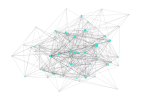

200

In [26]:
# lance l'animation

using GraphPlot, Colors

ITERATIONS = 200  # nombre d'itérations
TIMESTEP = 0.02   # pas de temps
INITSIZE = 3.0    # taille initiale
FRICTION = 300.0  # coefficient de friction (atténue les oscillations)

dig = loadgraph("data/0001.lg")
g = SimpleGraph(dig) # ignores direction of edges
degs = degree(g)
N = nv(g)
coord = random_layout(N, INITSIZE; seed=1)
speed = fill(0.0, N, 2)
force = fill(0.0, N, 2)
for i in 1:ITERATIONS
    print(lpad(i,3,"0"))
    spring_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
    display(gplot(g, coord[:,1], coord[:,2], edgestrokec=RGBA(0,0,0,.1), nodesize=degs))
    IJulia.clear_output(true)
    sleep(TIMESTEP)
end

### Évaluation du modèle

Avec cette animation, nous avons vu l'évolution du système et pouvons maintenant le confronter à nos critères de qualité.

In [27]:
using ProgressMeter

energy_model = fill(NaN, ITERATIONS)
intersects = fill(0, ITERATIONS)
noack_1_val = fill(NaN, ITERATIONS)

coord = random_layout(N, INITSIZE; seed=1)
speed = fill(0.0, N, 2)
force = fill(0.0, N, 2)
@showprogress "Running... " for i in 1:ITERATIONS
    spring_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
    D = pairwise(Euclidean(), coord, dims=1)
    energy_model[i] = sum(((D[e.src,e.dst]-1)^2 for e in edges(g)))
    intersects[i] = count_intersects(g, coord)
    noack_1_val[i] = noack_1(g, D)
end

Running... 100%|████████████████████████████████████████| Time: 0:00:10


In [28]:
using Plots
plotly()

energy = plot(energy_model); title!("energy model") # self defined energy model
inters = plot(intersects); title!("number of intersections")
noack1 = plot(noack_1_val); title!("noack model")
plot(size=(900, 400), energy, inters, noack1, legend=false, layout=@layout([a b c]))
xlabel!("iteration")

On constate que quel que soit le critère, le résultat après 200 itérations de l'algorithme est meilleur que la position aléatoire initiale. Mais avant de détailler les paramètres de la simulation, on peut faire certaines remarques sur une évaluation visuelle du graphe :

1. Certains points sont très proches les uns des autres. En effet, rien n'empêche que deux points non liés par une arête soient superposés. Cela nuit à la lisibilité de graphe, et sera à prendre en compte dans le prochain modèle.
2. Les nombreux liens entre les noeuds et la longueur à l'équilibre des arêtes contraignent le graphe à être resserré sur lui même. En conséquence, le nombre d'intersections diminue relativement peu entre la position aléatoire initiale (18600) et la position finale (15000).
3. La graphe est très petit (59 noeuds) et pourtant le résultat est peu lisible. Cet algorithme ne semble pas prometteur pour des graphes plus grands.

## Répulsion électrostatique

Au vu des faiblesses du premier modèle simple, on peut ajouter une force de répulsion électrostatique combinée à une force de ressort de longueur à l'équilibre nulle en effet, la longueur à l'équilibre sera définie par l'équilibre entre la force attractive et la force répulsive. Commençons par illustrer l'équilibre.

In [29]:
# illustration des forces

d = range(0,5,length=200)
spring = d
electro = -1 ./ d.^2
p1 = plot()
ylims!(-10, 10); xlabel!("distance"); ylabel!("force")
plot!(d,spring, label="spring attraction")
plot!(d,electro, label="electrostatic repulsion")
plot!(d,spring + electro, label="sum")

# et du point de vue de l'énergie potentielle

d = range(0,3,length=200)
spring = d.^2 ./2
electro = 1 ./ d
p2 = plot()
ylims!(0, 5); xlabel!("distance"); ylabel!("energy")
plot!(d,spring, label=false)
plot!(d,electro, label=false)
plot!(d,spring + electro, label=false)

plot(size=(900,400),p1,p2,legend=:topleft)

On a bien un minimum d'énergie, et donc un équilibre pour une distance unitaire. On remarque de plus que la force répulsive est très faible à grande distance mais énorme à distance faible. Implémentons ces forces.

In [30]:
"""updates force vector with attractive linear force for each node trough edge"""
function linear!(g::SimpleGraph, coord::Matrix{Float64}, force::Matrix{Float64})
    for e in edges(g)
        a = e.src; b = e.dst
        AB = coord[b,:] - coord[a,:] # vector AB
        force[a,:] += AB
        force[b,:] -= AB
    end
end

linear!

In [31]:
"""updates force vector with repulsive quadratic force applying on each point"""
function quadratic!(coord::Matrix{Float64}, force::Matrix{Float64})
    N = size(coord, 1)
    for i in 1:N
        for j in 1:i-1
            IJ = coord[j,:] - coord[i,:] # vector IJ
            α = 1 / sum(IJ.^2) # 1/d² factor
            Fi = -α.*IJ # repulsive force J/I
            force[i, :] += Fi
            force[j, :] -= Fi # opposite force
        end
    end
end

coord = [0.0 0.0 ; 1.0 1.0]; force = [0.0 0.0 ; 0.0 0.0]
quadratic!(coord, force)
@test force == [-0.5 -0.5 ; 0.5 0.5]

Test Passed

In [32]:
"""iterates one step of spring + electrostatic force"""
function spring_electrostatic_iteration!(g, coord, speed, force, dt, friction)
    coord .+= speed .* dt
    speed .+= force .* dt
    force[:] .= 0.0 # reinit forces before computing
    linear!(g, coord, force) # compute spring attraction
    quadratic!(coord, force) # compute quadratic repulsion
    force .-= friction .* speed .* dt # friction force
    coord .-= mean(coord, dims=1) # center coordinates
end

spring_electrostatic_iteration!

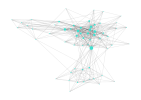

200

In [33]:
# lance l'animation

using GraphPlot, Colors

ITERATIONS = 200  # nombre d'itérations
TIMESTEP = 0.02   # pas de temps
INITSIZE = 4.0    # taille initiale
FRICTION = 200.0  # coefficient de friction (atténue les oscillations)

dig = loadgraph("data/0001.lg")
g = SimpleGraph(dig) # ignores direction of edges
degs = degree(g)
N = nv(g)
coord = random_layout(N, INITSIZE; seed=1)
speed = fill(0.0, N, 2)
force = fill(0.0, N, 2)
for i in 1:ITERATIONS
    print(lpad(i,3,"0"))
    spring_electrostatic_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
    display(gplot(g, coord[:,1], coord[:,2], edgestrokec=RGBA(0,0,0,.1), nodesize=degs))
    IJulia.clear_output(true)
    sleep(TIMESTEP)
end

### Évaluation du modèle

Confrontons ce second modèle à nos critères de qualité.

In [34]:
energy_model = fill(NaN, ITERATIONS)
spring_model = fill(NaN, ITERATIONS)
electr_model = fill(NaN, ITERATIONS)
intersects = fill(0, ITERATIONS)
noack_1_val = fill(NaN, ITERATIONS)

function self_energy_model(g, D)
    N = nv(g)
    mask = fill(true, (N,N))
    tril!(mask, -1)
    spring = sum( (D[e.src,e.dst]^2/2 for e in edges(g)) )
    electro = sum(1 ./D[mask])
    return (spring, electro, spring + electro)
end    

coord = random_layout(N, INITSIZE; seed=1)
speed = fill(0.0, N, 2)
force = fill(0.0, N, 2)
@showprogress "Running... " for i in 1:ITERATIONS
    spring_electrostatic_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
    D = pairwise(Euclidean(), coord, dims=1)
    spring_model[i], electr_model[i], energy_model[i] = self_energy_model(g, D)
    intersects[i] = count_intersects(g, coord)
    noack_1_val[i] = noack_1(g, D)
end

Running... 100%|████████████████████████████████████████| Time: 0:00:09


In [35]:
energy = plot(energy_model); title!("energy model") # self defined energy model
plot!(spring_model); plot!(electr_model);
inters = plot(intersects); title!("number of intersections")
noack1 = plot(noack_1_val); title!("noack model")
plot(size=(900, 400), energy, inters, noack1, legend=false, layout=@layout([a b c]))
xlabel!("iteration")

On remarque que pour le même graphe, ce modèle est bien plus performant suivant tous les critères. Il permet de passer à un nombre d'intersections bien moindre (18600→6900 contrairement à 15000 précédemment) et répond bien mieux au critère de Noack (1.15→0.54 contre 0.95 précédemment).

On peut également examiner les deux composantes du modèle d'énergie propre : dans un premier temps (0-30), l'énergie liée au ressort diminue fortement, en même temps qu'une légère augmentation de la force électrostatique. Dans un deuxième temps (30-200), c'est l'énergie électrostatique qui diminue. Cette transition correspond à un léger palier dans le nombre d'intersections et le modèle de Noack. On peut donc supposer que la présence simultanée des deux forces soit gênante à cette étape et chercher à réaliser des modèles en plusieurs phases : d'abord ressort uniquement, ensuite ajout de la force électrostatique. Mais nous n'explorerons pas de tels modèles ici.

### Sensibilité aux conditions initiales

Les conditions initiales ont pour l'instant été laissées au hasard mais on peut se demander quelle est leur importance. En effet, quel est le risque de tomber dans un minimum local, peut-on réduire le temps de convergence ? Pour répondre à ces questions, nous allons lancer plusieurs fois le modèle en faisant varier les paramètres.

#### Taille du carré initial

In [36]:
init_size = 0.5:0.3:4 # border of initial square
SAMPLE = length(init_size)
ITERATIONS = 100

energy_model = fill(NaN, (ITERATIONS, SAMPLE))
spring_model = fill(NaN, (ITERATIONS, SAMPLE))
electr_model = fill(NaN, (ITERATIONS, SAMPLE))

@showprogress "Running... " for (j,INITSIZE) in enumerate(init_size)
    coord = random_layout(N, INITSIZE; seed=1)
    speed = fill(0.0, N, 2)
    force = fill(0.0, N, 2)
    for i in 1:ITERATIONS
        spring_electrostatic_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
        D = pairwise(Euclidean(), coord, dims=1)
        spring_model[i,j], electr_model[i,j], energy_model[i,j] = self_energy_model(g, D)
    end
end

Running... 100%|████████████████████████████████████████| Time: 0:00:01


In [37]:
using Colors

colors = range(HSL(colorant"red"), stop=HSL(colorant"green"), length=SAMPLE)

energy = plot(energy_model, label=string.(init_size')); title!("energy")
spring = plot(spring_model, label=false); title!("spring")
electr = plot(electr_model, label=false); title!("electrostatic")
plot(size=(900, 500), electr, spring, energy, layout=@layout([[a;b] c]),
    linewidth=2, linecolor=colors', legend=:topright)

La taille de la disposition initiale ne semble pas modifier significativement la convergence.

#### Distribution aléatoire initiale

Dans l'exemple précédent, nous avons uniquement fait varier la taille initiale (même graîne). Maintenant, examinons à quel point la distribution aléatoire peut être importante. Pour cet exemple, nous allons avoir besoin d'une implémentation un peu plus efficace en terme de mémoire de notre algorithme. Pour cela, nous pouvons aider le compilateur en précisant les coordonnées (x,y) dans des variables plutôt que dans un vecteur, ce qui lui évite de réaliser des allocation inutiles au prix d"une perte de généralité en terme de dimensions. Nous pouvons également utiliser des macros d'optimisation de la compilation comme `@inbounds`, `@fastmath` ou `@simd` (cf l'aide pour plus d'info).

In [38]:
@time quadratic!(coord, force) # on remarque des allocations inutiles dans la fonction

  0.000886 seconds (15.40 k allocations: 1.410 MiB)


In [39]:
"""more efficient version of quadratic function"""
function quadratic!(coord::Matrix{Float64}, force::Matrix{Float64})
    N = size(coord, 1)
    @inbounds for i in 1:N
        for j in 1:i-1
            IJx = coord[j,1] - coord[i,1]
            IJy = coord[j,2] - coord[i,2]
            α = 1 / (IJx^2+IJy^2)
            Fix = -α*IJx
            Fiy = -α*IJy
            force[i, 1] += Fix; force[i, 2] += Fiy
            force[j, 1] -= Fix; force[j, 2] -= Fiy
        end
    end
end
"""more efficient version of linear function"""
function linear!(g::SimpleGraph, coord::Matrix{Float64}, force::Matrix{Float64})
    for e in edges(g)
        a = e.src; b = e.dst
        ABx = coord[b,1] - coord[a,1]
        ABy = coord[b,2] - coord[a,2]
        force[a,1] += ABx; force[a,2] += ABy
        force[b,1] -= ABx; force[b,2] -= ABy
    end
end

@time quadratic!(coord, force) # cette version ne realise aucune allocation !

  0.000006 seconds


In [40]:
SAMPLE = 5000
seeds = 1:SAMPLE
ITERATIONS = 300
INITSIZE = 3.0

energy_model = fill(NaN, (2, SAMPLE))

@showprogress "Running... " for (j,SEED) in enumerate(seeds)
    coord = random_layout(N, INITSIZE; seed=SEED)
    speed = fill(0.0, N, 2)
    force = fill(0.0, N, 2)
    _, _, energy_model[begin,j] = self_energy_model(g, pairwise(Euclidean(), coord, dims=1))
    for i in 1:ITERATIONS
        spring_electrostatic_iteration!(g, coord, speed, force, TIMESTEP, FRICTION)
    end
    _, _, energy_model[end,j] = self_energy_model(g, pairwise(Euclidean(), coord, dims=1))
end

Running... 100%|████████████████████████████████████████| Time: 0:00:13


In [41]:
p1 = histogram(energy_model[end,:], bins=20); xlabel!("energy distribution at the end")
p2 = scatter(energy_model[begin,:], energy_model[end,:], markeralpha=0.1, markerstrokewidth=0)
xlabel!("energy at the beginning"); ylabel!("energy at the end"); 
plot(size=(900,400),p1,p2,legend=false)

In [42]:
using Statistics

std(energy_model[end,:])/mean(energy_model[end,:])

0.012011456464023051

Pour une distribution initiale aléatoire, la variabilité du niveau d'énergie final est de l'ordre de 1% sans corrélation apparente avec le niveau d'énergie initial. Les différentes positions aléatoire se valent donc à peu près.

## Références

#1 [thèse d'Andreas Noack][1]

[1]: https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=5917DE208FC837615846E3F8E42B8ACF?doi=10.1.1.628.2906&rep=rep1&type=pdf "Andreas Noack"
[2]: https://doi.org/10.1002/spe.4380211102 "Fruchterman-Reingold"